In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import glob

In [ ]:

def load_emg_data(base_path):
    normal_activities = [
        'Bowing', 'Clapping', 'Handshaking', 'Hugging', 'Jumping', 
        'Running', 'Seating', 'Standing', 'Walking', 'Waving'
    ]
    
    aggressive_activities = [
        'Elbowing', 'Frontkicking', 'Hamering', 'Headering', 'Kneeing', 
        'Pulling', 'Punching', 'Pushing', 'Sidekicking', 'Slapping'
    ]
    
   
    muscle_columns = [
        'R_Bic', 'R_Tri', 'L_Bic', 'L_Tri', 
        'R_Thi', 'R_Ham', 'L_Thi', 'L_Ham'
    ]
    
   
    all_data = []
    
   
    for subject_id in range(1, 5): 
        subject_path = os.path.join(base_path, f'sub{subject_id}')
        
       
        for activity_type in ['Aggressive', 'Normal']:
            type_path = os.path.join(subject_path, activity_type, 'txt')
            
           
            activity_files = glob.glob(os.path.join(type_path, '*.txt'))
            
            
            for file_path in activity_files:
               
                activity_name = os.path.splitext(os.path.basename(file_path))[0]
                
               
                try:
                    
                    df = pd.read_csv(file_path, header=None, delim_whitespace=True)
                    
                   
                    df.columns = muscle_columns
                    
                   
                    df['subject_id'] = subject_id
                    df['activity_type'] = activity_type
                    df['activity_name'] = activity_name
                    
                    
                    df['repetition_id'] = len(all_data) + 1
                    
                    all_data.append(df)
                
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
 
    final_dataset = pd.concat(all_data, ignore_index=True)
    
    return final_dataset

In [ ]:

def prepare_classification_data(dataset):

    X = dataset.drop(['subject_id', 'activity_type', 'activity_name', 'repetition_id'], axis=1)
    y = dataset['activity_type']
    
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
   
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test

In [ ]:
def plot_emg_time_series(dataset):
    muscle_columns = [
        'R_Bic', 'R_Tri', 'L_Bic', 'L_Tri', 
        'R_Thi', 'R_Ham', 'L_Thi', 'L_Ham'
    ]
    
    ## Unique activities
    activities = dataset['activity_name'].unique()
    
    
    n_activities = len(activities)
    n_cols = min(3, n_activities)
    n_rows = int(np.ceil(n_activities / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('EMG Time Series for Different Activities', fontsize=16)
    axes = axes.flatten() if n_activities > 1 else [axes]
    
    for idx, activity in enumerate(activities):
        activity_data = dataset[dataset['activity_name'] == activity]
        ax = axes[idx]
        for muscle in muscle_columns:
            plot_data = activity_data[muscle].values[:100]  
            ax.plot(plot_data, label=muscle)
        
        ax.set_title(f'EMG - {activity}')
        ax.set_xlabel('Time Points')
        ax.set_ylabel('EMG Amplitude')
        ax.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    
    for idx in range(len(activities), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def train_knn_classifier(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_neighbors=5)
    y_pred = knn.predict(X_test)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    return knn, report, conf_matrix

In [ ]:

def train_classifier(X_train, X_test, y_train, y_test):
    
    clf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    return clf, report, conf_matrix

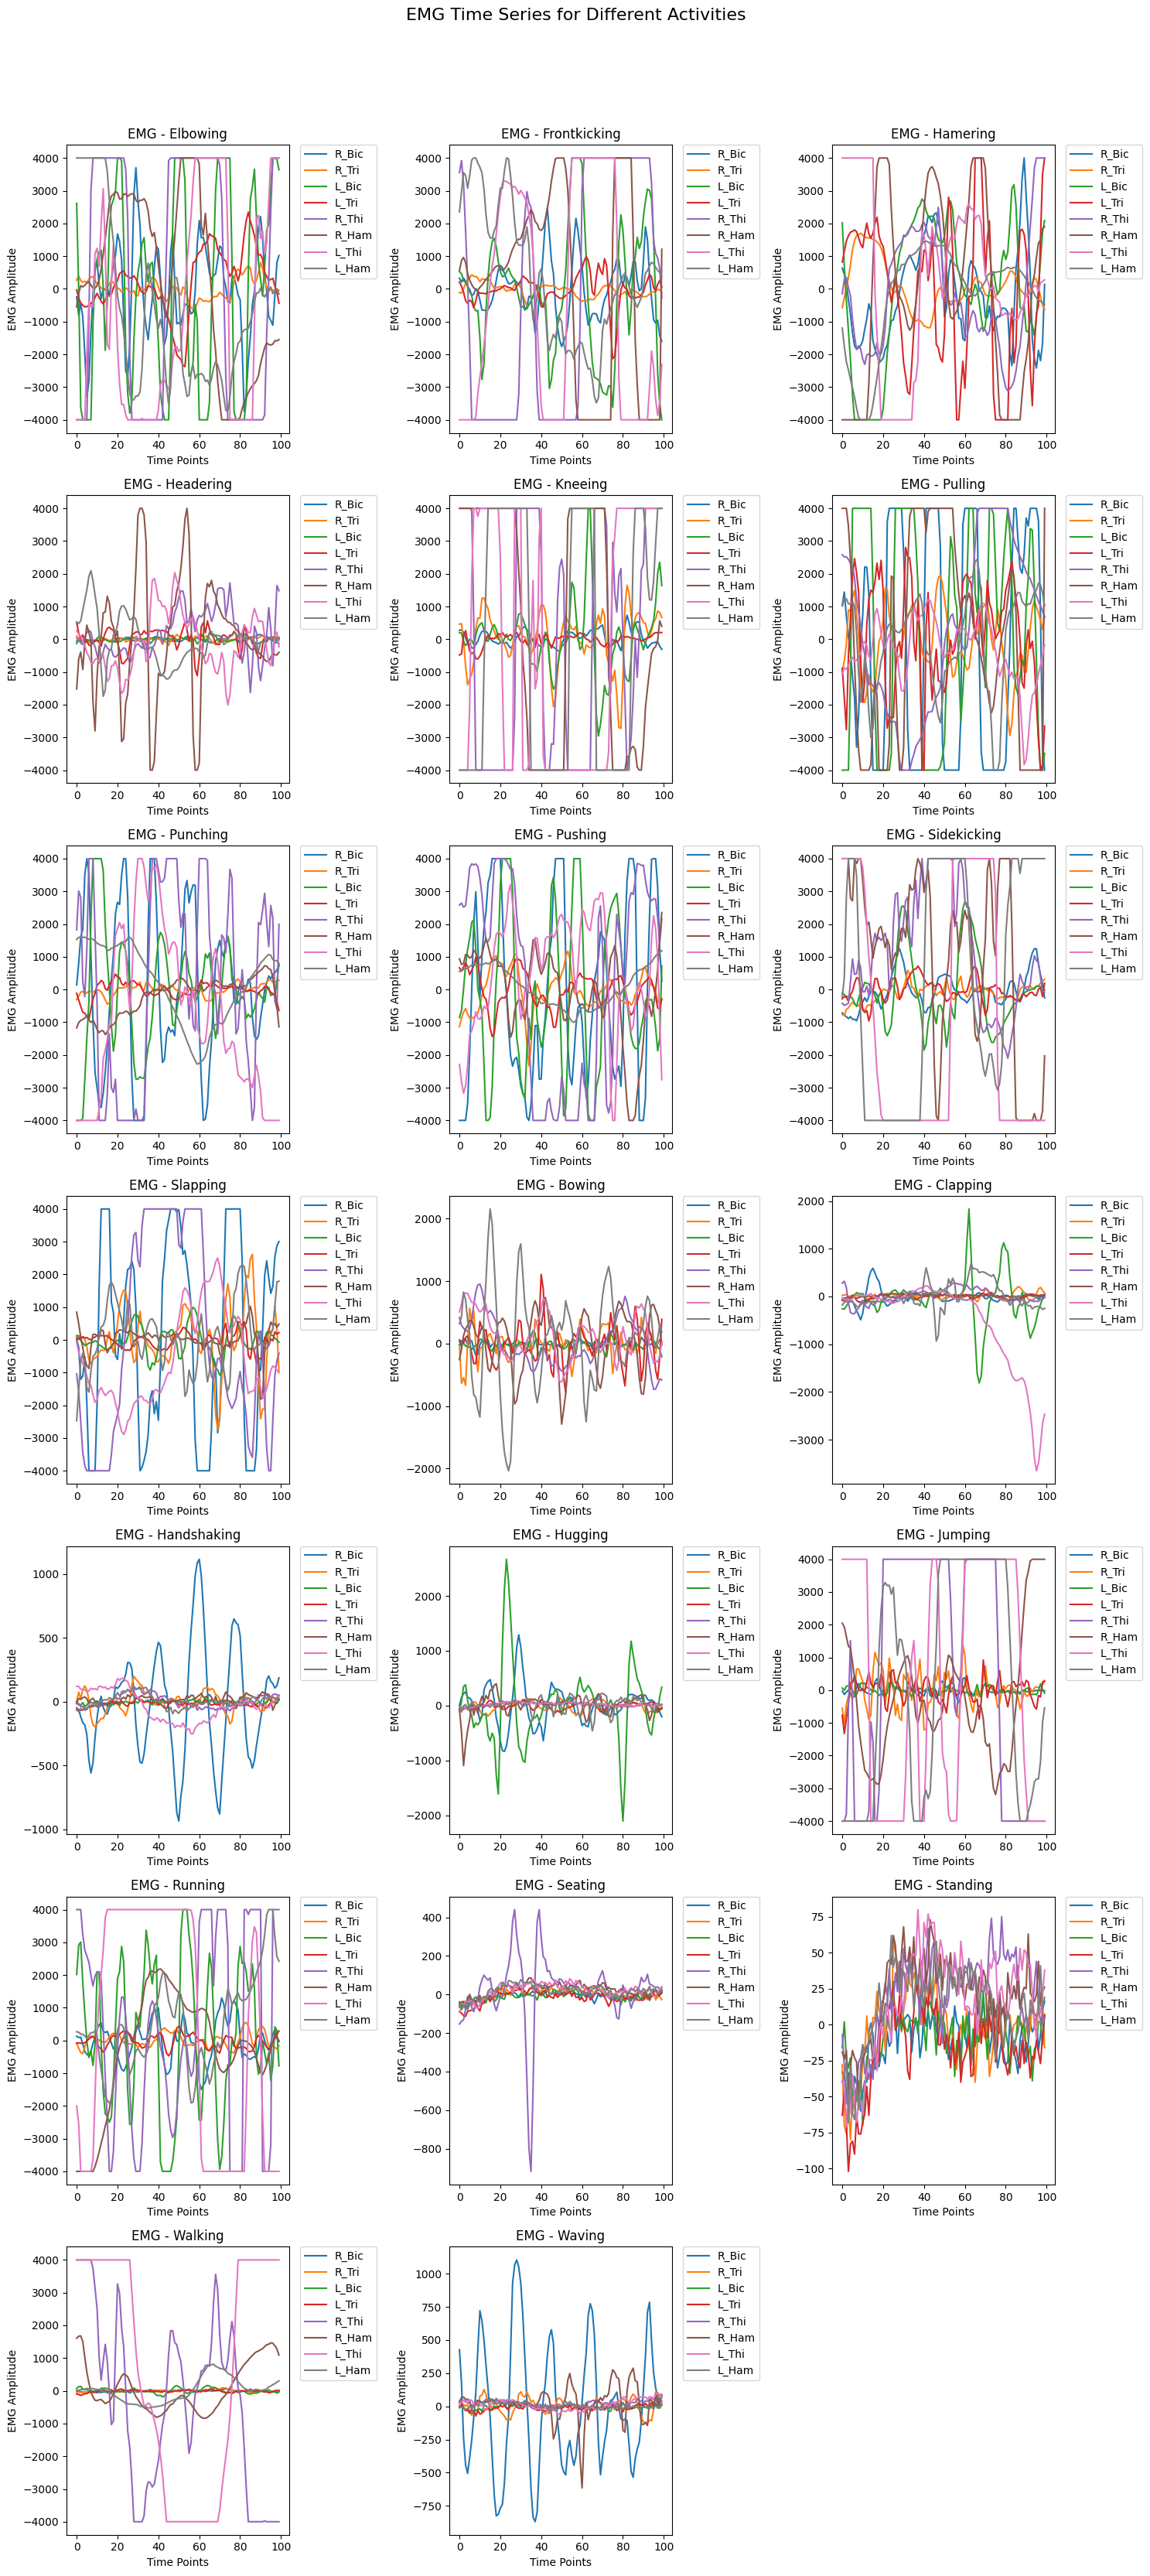

Random Forest Classification Report:
              precision    recall  f1-score   support

  Aggressive       0.88      0.94      0.91     80032
      Normal       0.94      0.87      0.90     79454

    accuracy                           0.91    159486
   macro avg       0.91      0.91      0.90    159486
weighted avg       0.91      0.91      0.91    159486


Random Forest Confusion Matrix:
[[75602  4430]
 [10695 68759]]


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

  Aggressive       0.90      0.85      0.88     80032
      Normal       0.86      0.91      0.88     79454

    accuracy                           0.88    159486
   macro avg       0.88      0.88      0.88    159486
weighted avg       0.88      0.88      0.88    159486


K-Nearest Neighbors Confusion Matrix:
[[68052 11980]
 [ 7168 72286]]


In [23]:
def main(base_path):
    emg_dataset = load_emg_data(base_path)
    
    plot_emg_time_series(emg_dataset)
    X_train, X_test, y_train, y_test = prepare_classification_data(emg_dataset)
    
    rf_classifier, rf_report, rf_confusion_matrix = train_classifier(
        X_train, X_test, y_train, y_test
    )
    
    knn_classifier, knn_report, knn_confusion_matrix = train_knn_classifier(
        X_train, X_test, y_train, y_test
    )
    
    print("Random Forest Classification Report:")
    print(rf_report)
    print("\nRandom Forest Confusion Matrix:")
    print(rf_confusion_matrix)
    
    # Print KNN results
    print("\n\nK-Nearest Neighbors Classification Report:")
    print(knn_report)
    print("\nK-Nearest Neighbors Confusion Matrix:")
    print(knn_confusion_matrix)
    return emg_dataset, rf_classifier, knn_classifier



if __name__ == "__main__":
   
    base_path = r"data"
    
    dataset, rf_model, knn_model = main(base_path)

In [22]:

# # Example usage
# if __name__ == "__main__":
#     # Replace with the actual base path to your dataset
#     base_path = r"data"
    
#     # Run the main function
#     dataset, rf_model, knn_model = main(base_path)

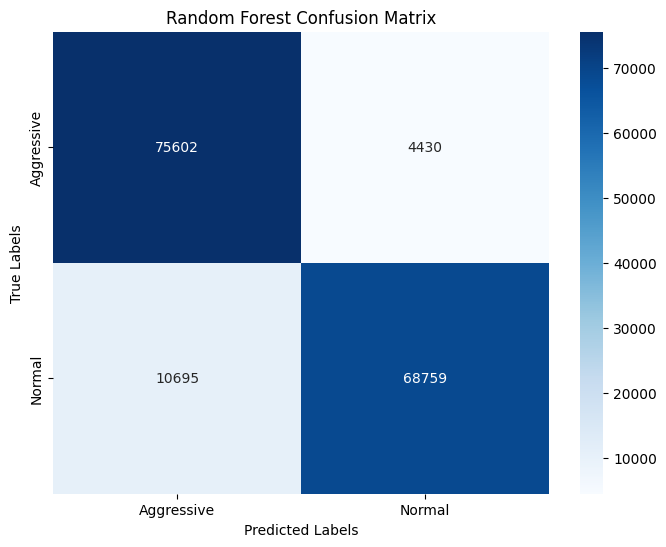

In [24]:
import numpy as np

# Data for the confusion matrix
rf_confusion_matrix = np.array([[75602, 4430], [10695, 68759]])

# Labels for the axes
categories = ['Aggressive', 'Normal']

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)

plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


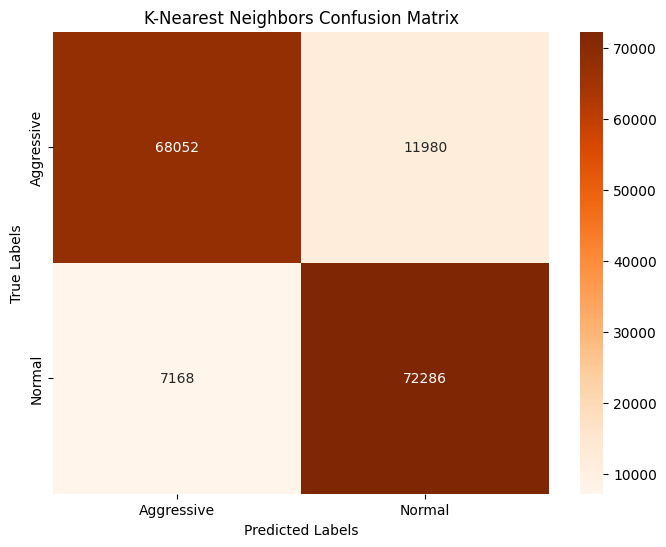

In [25]:
# Data for the confusion matrix
knn_confusion_matrix = np.array([[68052, 11980], [7168, 72286]])

# Labels for the axes
categories = ['Aggressive', 'Normal']

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(knn_confusion_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=categories, yticklabels=categories)

plt.title("K-Nearest Neighbors Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
